#**HOMEWORK 2: REAL ESTATE PRICE PREDICTION (Total: / 25 points)**

# *Names: (Aditya Sinha, Chinar Boolchandani)*

Make sure that you answer the two conceptual questions provided at the front of the notebook (edit the XXX response sections to provide your answers). You probably want to answer these last, after you finish the hands-on portion of the assignment. 

#*Background: Use Case*

Your task here is to use the supplied dataset describing homes, including four photos per home and some other structured features, along with an associated home sale price label, to try to fit a predictive model of sale price.

The use case here is as follows. Your customers are individual sellers, buyers, and real estate agent, who wishes to set their sale price, or their offer price on a new home. You can assume the user will always have these features available to them at the time of prediction (i.e., the four photo types in question, as well as the structured features). 

#**Answers to Written Questions (2 points)**

**Question 1: Why is it necessaty to resize the images? What impact, conceptually, would the choice of image size have on the prediction task, computationally / practically, but also in terms of prediction performnace (note: I'm not asking you try out different sizes to see what happens; I'm asking you to think about 'why' a choice of a smaller vs. larger image resizing would matter.)**


**Answer**:</br>
Resizing the images to smaller size leads to shrinking of its features/pixels.
Less shrinking means less deformation of features and patterns inside the image, which can lead to drop in the prediction performance of a CNN model.</br>
On the other hand, larger image size would favor fine grained problems , i.e. prediction performance would be better but at the expense of computation time that goes in processing and learning from those detailed features and patterns in the large images.</br>
Image downsizing also helps with removing any noisy pixels that might not be helpful in our model's classification task.<br/>
Moreover, most deep learning model architectures require that our images are the same size and our raw collected images may vary in size. So, we might have to resize all the image to same size for our ML model to process.





**Question 2: Are there any predictors that you decided to discard here (numeric or image-based)? Why or why not; what did you consider when making these choices? Did you add any features? What, and why?**

We decided to keep all the features:


*   Numerical Data
    * \# of bedrooms: Number of bedrooms is directly realted to price of a house, the more bedrooms , the higher the price of a property.
    * \# of bathrooms: Number of bathrooms is directly realted to price of a house, the more bathrooms , the higher the price of a property.
    * area: Directly related to price of a house, the bigger the area , higher is the price of the house.
    * zipcode: Some zipcodes will belong to places closer to main cities and urban areas where demand for property is higher , those zipcodes will have pricier houses compared to some other suburb or rural areas.

*   Image Data
    
    * Bedrooms: Well maintained and furshined bedroom impacts the house prices in a positive way whereas if the bedroom is smaller and dont not come with enough facilities house prices will be lower.
    * Bathrooms: Well maintained and furshined bathroom impacts the house prices in a positive way whereas if the bathroom is smaller and does not come with enough facilities house prices will be lower.
    * Kitchen: Well maintained and furshined kitchen impacts the house prices in a positive way whereas if the kitchen is smaller and does not come with enough facilities house prices will be lower.
    * Frontal: How the house looks from outside and how big the frontal area also impacts the house price.

We also performed some pre-processing on numerical data:

*   We used RobustScaler to scale the area, # of bedrooms, # of bathrooms to standardize data.
*   We used OneHotEconder to encode different zipcodes to 0s and 1s.

Features Addition

*   Using zip code and pgeocode API, we added latitude and longitude which helped us increase the model performance. As, location usually is the main driver of house prices.

Feature Discard

* Zip code count is highly unbalanced with some zip codes with only 1 or 2 houses. We tried sanitizing our dataset by removing those houses but it didn't help our model performace so we decided to keep it in there.

#**Importing the Data**

I've provided some starter code for importing the data...

In [ ]:
!pip install pgeocode -q

import random
import numpy as np
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import glob
from PIL import Image
import pgeocode

seed = 865

random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

Mounted at /content/gdrive
The shape of our kitchen image array is (535, 128, 128, 3)


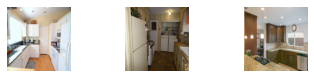

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

# Replace with your basepath to the extracted dataset in your Google Drive
basePath = '/content/gdrive/Shareddrives/BA865_Homework_Assignment/HM2/HM2-dataset/'

# These are the column headers for the home characteristics data.
cols = ['bedrooms','bathrooms','area','zipcode','price']

# We first pull in the numeric features for houses from the text file.
numericData = pd.read_csv(f'{basePath}/all/HousesInfo.txt', sep=" ", header=None, names=cols)

# Pulling out the labels
labels = numericData['price']

image_size = (128,128)

# Reading the images into memory may take a minute - be patient :).
def read_images(imageType):
  image_list = []
  for file in glob.glob(f"{basePath}/all/{imageType}/*"):
    im=Image.open(file)
    im=im.resize(size=image_size)
    image_list.append(np.divide(np.array(im),255))
  return np.stack(image_list)

front_image = read_images("frontal")
bathroom_image = read_images("bathroom")
bedroom_image = read_images("bedroom")
kitchen_image = read_images("kitchen")

print(f'The shape of our kitchen image array is {kitchen_image.shape}')

# Our 535 houses' images are all now in memory as 180, 180 pictures, with 3 channels (RGB). Feel free to change the image size.
for i in range(3):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(kitchen_image[i])
    plt.axis("off")

Shuffle the different arrays, in unison (preserving row ordering across the arrays).

In [ ]:
shuffled_indices= np.arange(front_image.shape[0])
np.random.shuffle(shuffled_indices)

front_image = front_image[shuffled_indices]
kitchen_image = kitchen_image[shuffled_indices]
bathroom_image = bathroom_image[shuffled_indices]
bedroom_image = bedroom_image[shuffled_indices]
numericData = numericData.iloc[shuffled_indices]
labels = labels[shuffled_indices]

In [ ]:
zip_code_list = list(numericData['zipcode'])
zip_code_list = [str(x) for x in zip_code_list]

nomi = pgeocode.Nominatim('us')
zip_code_info = nomi.query_postal_code(zip_code_list)
zip_code_info = zip_code_info[["latitude", "longitude" ]]

numericData["latitude"] = np.array(zip_code_info["latitude"])
numericData["longitude"] = np.array(zip_code_info["longitude"])

## Helper Function

In [ ]:
def get_model_fit_validate_cv(n, numericData, front_image, kitchen_image, bathroom_image, bedroom_image, labels, cnn_model, epochs, batchsize):
    k = n
    num_val_samples = len(numericData) // k # floor division (i.e., round down to nearest integer.)
    num_epochs = epochs
    batch_size = batchsize
    all_mae_histories = []  

    print("In total, we have",len(numericData),"training observations.")
    print("With a k of",k,"we have",num_val_samples,"observations per fold.\n")

    for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
        print("Processing fold #:",i)
        # if I slice past the end of the array, it just gives me what it can find! No errors.
        # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
        print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples-1) # minus 1 because a slice is up to and not including the second index.
        
        val_front_image = front_image[i * num_val_samples: (i + 1) * num_val_samples]
        val_kitchen_image = kitchen_image[i * num_val_samples: (i + 1) * num_val_samples]
        val_bathroom_image = bathroom_image[i * num_val_samples: (i + 1) * num_val_samples]
        val_bedroom_image = bedroom_image[i * num_val_samples: (i + 1) * num_val_samples]
        val_processed_numerical_input = numericData[i * num_val_samples: (i + 1) * num_val_samples]
        val_labels = labels[i * num_val_samples: (i + 1) * num_val_samples]

        print("Training data includes observations 0 through",i*num_val_samples-1,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")

        partial_front_image = np.concatenate(
            [front_image[:i * num_val_samples],
            front_image[(i + 1) * num_val_samples:]],
            axis=0)
        partial_kitchen = np.concatenate(
            [kitchen_image[:i * num_val_samples],
            kitchen_image[(i + 1) * num_val_samples:]],
            axis=0)
        partial_bathroom = np.concatenate(
            [bathroom_image[:i * num_val_samples],
            bathroom_image[(i + 1) * num_val_samples:]],
            axis=0)
        partial_bedroom = np.concatenate(
            [bedroom_image[:i * num_val_samples],
            bedroom_image[(i + 1) * num_val_samples:]],
            axis=0)
        partial_numerical = np.concatenate(
            [numericData[:i * num_val_samples],
            numericData[(i + 1) * num_val_samples:]],
            axis=0)
        partial_labels = np.concatenate(
            [labels[:i * num_val_samples],
            labels[(i + 1) * num_val_samples:]],
            axis=0)
        
        model = cnn_model()
        history = model.fit(x=[partial_numerical, partial_bedroom,partial_front_image, partial_kitchen,partial_bathroom],y=partial_labels, epochs=num_epochs, batch_size=batch_size, 
                  validation_data=([val_processed_numerical_input, val_bedroom_image,val_front_image, val_kitchen_image,val_bathroom_image], val_labels), verbose=0)
        mae_history = history.history['val_mae']
        all_mae_histories.append(mae_history)
    average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
    return average_mae_history

## Pre-processing

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder 
from sklearn.compose import ColumnTransformer

def processNumericalData(data_orignal):
    data = data_orignal.copy(deep=True)
    numeric_features = ['area', "bedrooms", "bathrooms", "latitude", "longitude"]
    numeric_transformer = Pipeline(steps=[("scaler", RobustScaler())])
    
    categorical_features = ['zipcode']
    categorical_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ])

    steps = [("preprocessor", preprocessor)]
    pipe = Pipeline(steps)
    X = data.drop('price', axis=1)
    predictors = pipe.fit_transform(X) 
    return predictors.toarray()

In [ ]:
numericData = processNumericalData(numericData)

#**Create a Multi-Modal NN from Scratch (13 points)**

#*Define Your Model*

Provide your code to implement a multi-modal NN. You should evaluate your model's loss in terms of mean absolute error (MAE).

In [ ]:
data_augmentation = keras.Sequential([
   layers.RandomFlip("horizontal_and_vertical"),
   layers.RandomRotation(0.1),
   layers.RandomZoom(0.2),
])

In [ ]:
def build_model():

    # Numerical Area
    numerical_input = layers.Input(shape=(numericData.shape[1],),name="Numerical")
    x = layers.Dense(50,activation="relu")(numerical_input)
    x = layers.Dense(25,activation="relu")(x)
    x = layers.Dense(10,activation="relu")(x)
    numeric_output = layers.Dense(4,activation="relu")(x)

    # Image bedroom
    input_image_bedroom = layers.Input(shape=(128,128,3), name="Bedroom Images")

    x = data_augmentation(input_image_bedroom)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(64, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=None)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    image_output_bedroom = layers.Dense(1)(x)


    # Image front_image
    input_image_front = layers.Input(shape=(128,128,3), name="Front Images")
    
    x = data_augmentation(input_image_front)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(64, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=None)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    image_output_front = layers.Dense(1)(x)

    # Image kitchen_image
    input_image_kitchen = layers.Input(shape=(128,128,3), name="Kitchen Images")

    x = data_augmentation(input_image_kitchen)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(64, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=None)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    image_output_kitchen = layers.Dense(1)(x)

    # Image bathroom_image
    input_image_bathroom = layers.Input(shape=(128,128,3), name="Bathroom Images")

    x = data_augmentation(input_image_bathroom)
    x = layers.Rescaling(1./255)(x)
    x = layers.Conv2D(128, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)
    x = layers.Conv2D(64, kernel_size=2, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = layers.MaxPooling2D(pool_size=2, strides=None)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(16, activation="relu")(x)
    image_output_bathroom = layers.Dense(1)(x)

    merge = layers.Concatenate()([image_output_bathroom,image_output_kitchen,image_output_front,image_output_bedroom, numeric_output])
    x = layers.Dense(5,activation="relu")(merge)
    final_output = layers.Dense(1, activation ="relu")(x)

    branch_model = keras.Model(inputs=[numerical_input,input_image_bedroom,input_image_front,input_image_kitchen, input_image_bathroom],outputs=final_output)
    branch_model.compile(optimizer="adam",loss="mae", metrics=["mae"])
    return branch_model

#*Fit Your Model*

Train your model and track validation loss in terms of MAE.

In [ ]:
average_mae_history = get_model_fit_validate_cv(5, numericData, front_image, kitchen_image, 
                                                bathroom_image, bedroom_image, labels, build_model, 100, 16)

In total, we have 535 training observations.
With a k of 5 we have 107 observations per fold.

Processing fold #: 0
Validation data includes observations 0 through 106
Training data includes observations 0 through -1 joined with observations 107 through the final observation.

Processing fold #: 1
Validation data includes observations 107 through 213
Training data includes observations 0 through 106 joined with observations 214 through the final observation.

Processing fold #: 2
Validation data includes observations 214 through 320
Training data includes observations 0 through 213 joined with observations 321 through the final observation.

Processing fold #: 3
Validation data includes observations 321 through 427
Training data includes observations 0 through 320 joined with observations 428 through the final observation.

Processing fold #: 4
Validation data includes observations 428 through 534
Training data includes observations 0 through 427 joined with observations 535 through th

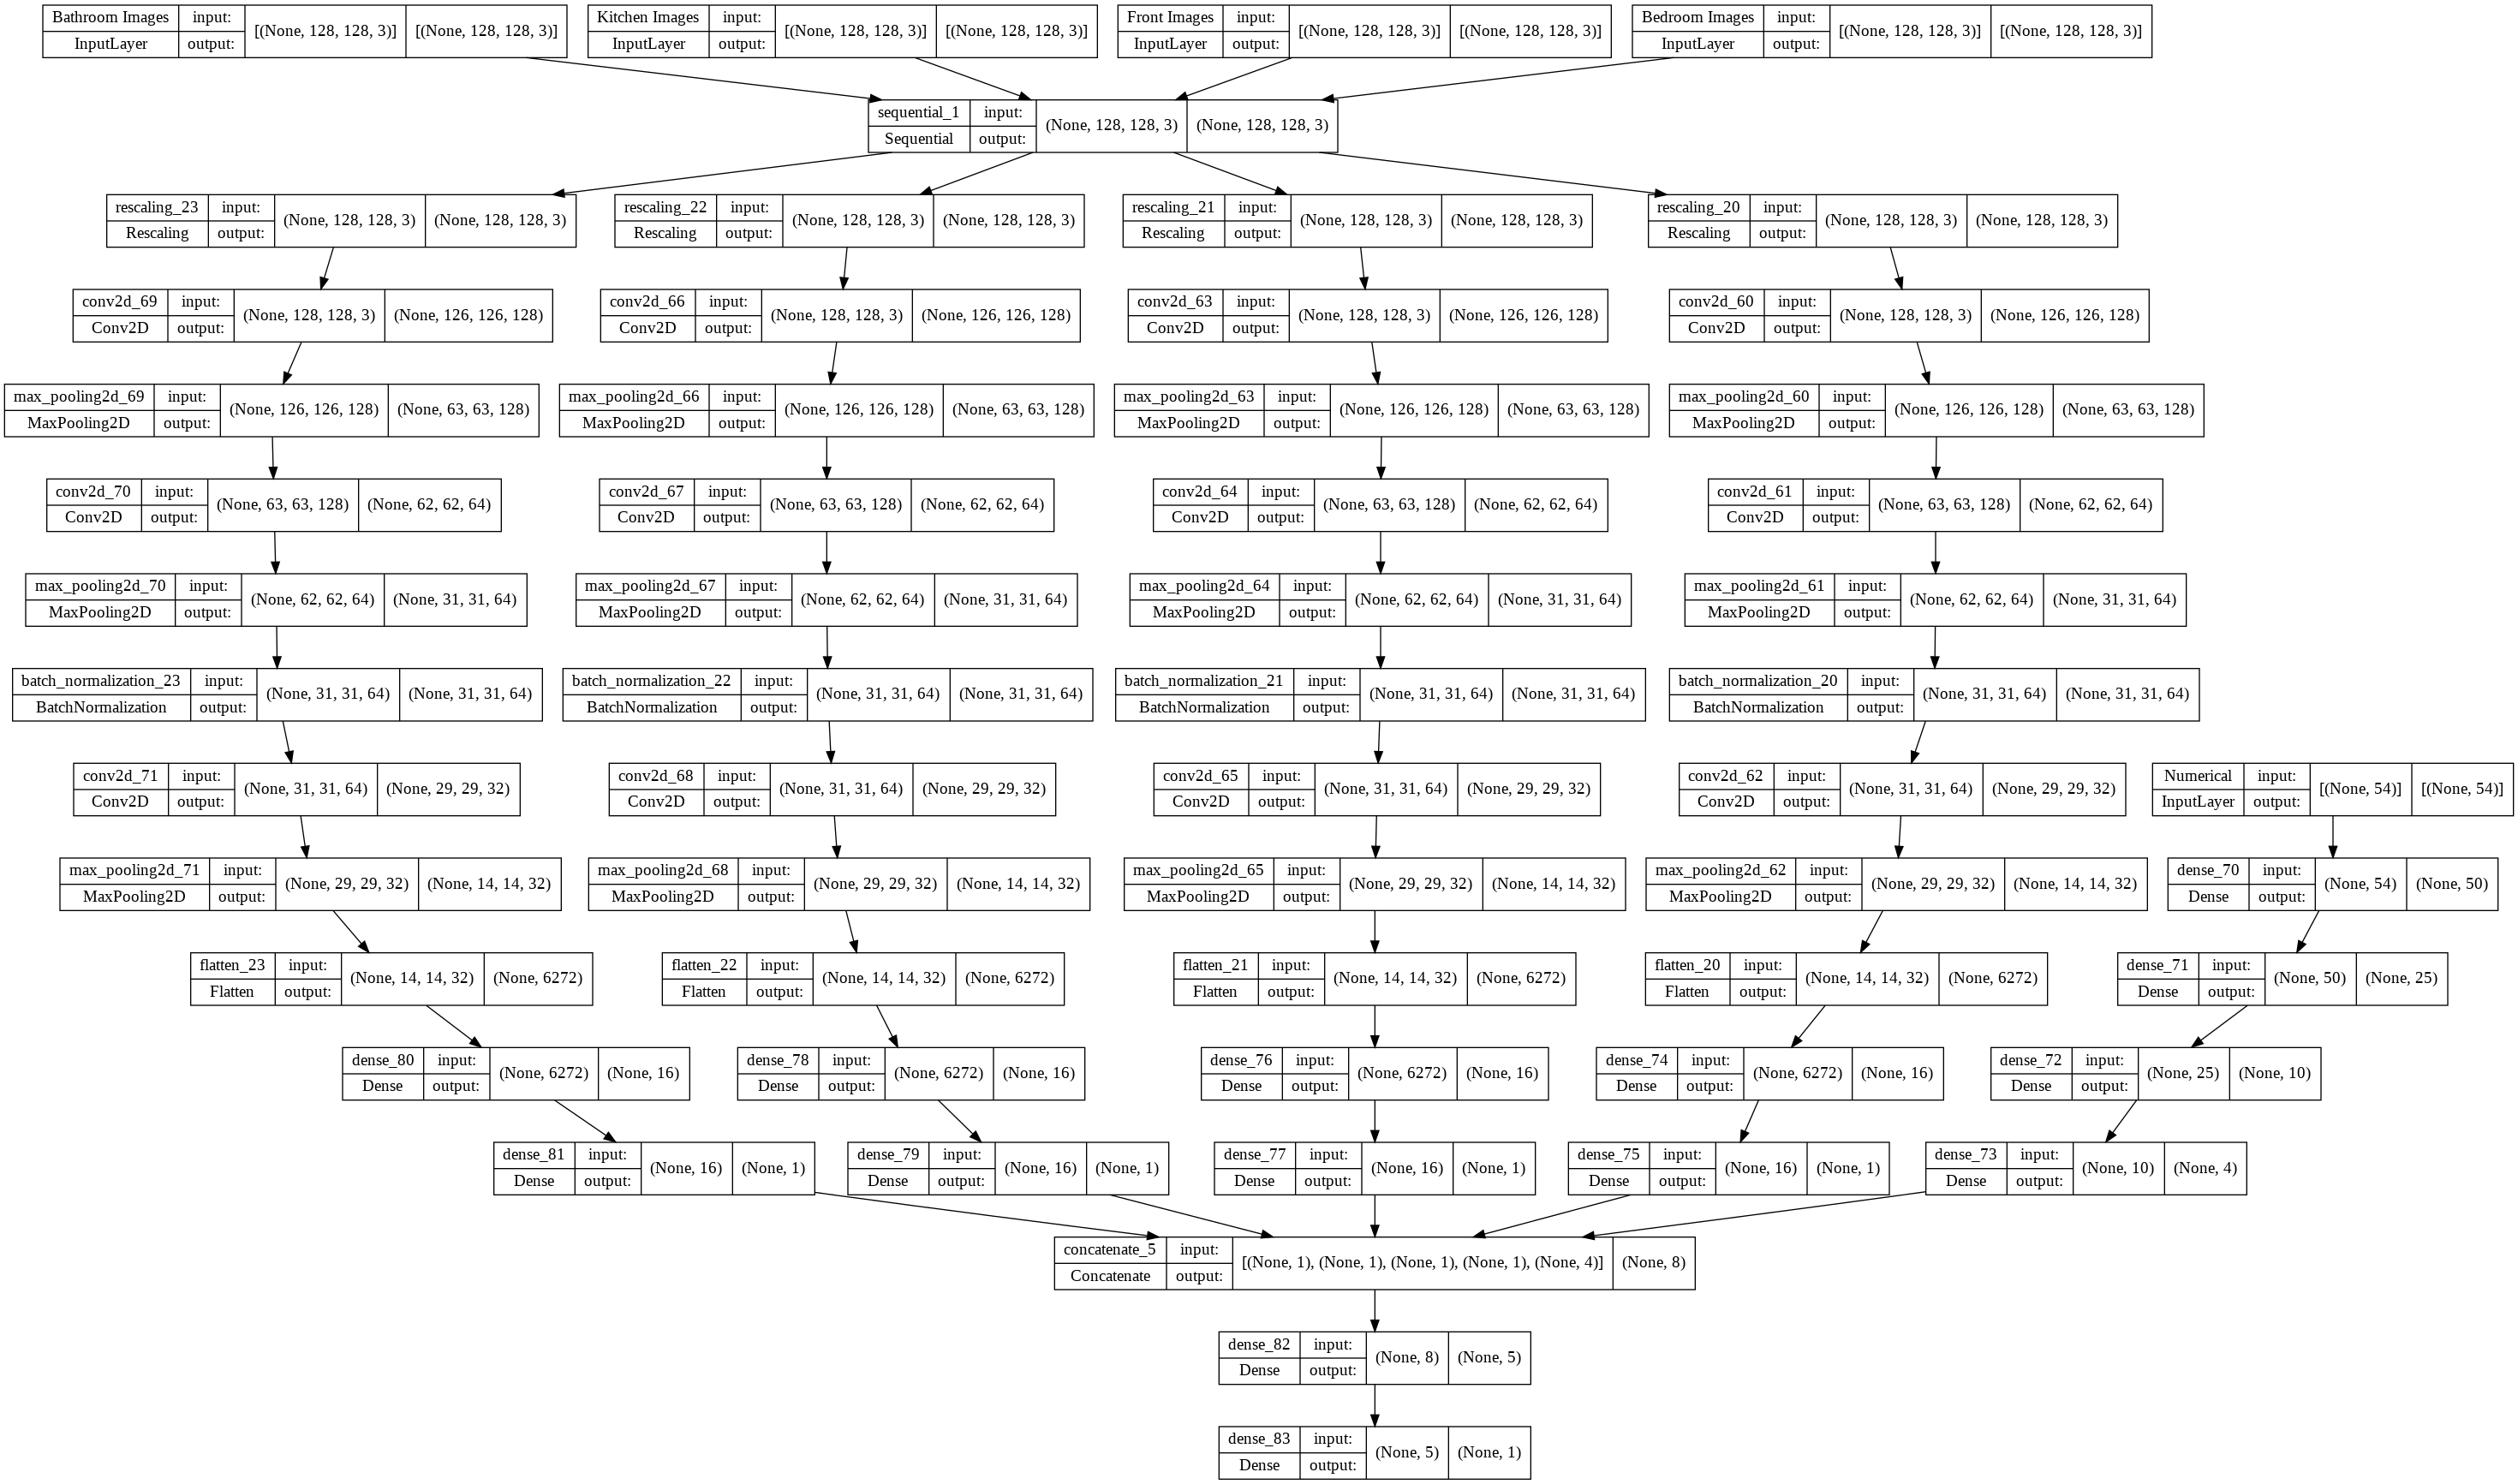

In [ ]:
keras.utils.plot_model(build_model(), show_shapes=True)

Plot your model's loss over epochs to undertand fitting / overfitting.

160439.2546875


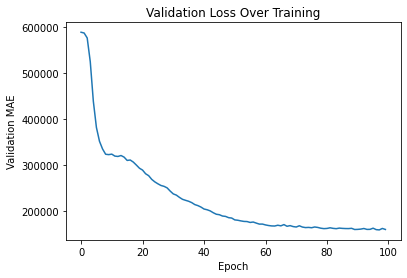

In [ ]:
import matplotlib.pyplot as plt

print(average_mae_history[-1])

plt.plot(average_mae_history)
plt.ylabel('Validation MAE')
plt.xlabel('Epoch')
plt.title('Validation Loss Over Training')
plt.show()

#**Now Use a Pre-Trained Model (10 points)**

In this section, you should replace the CNN components of your 'from-scratch' multi-modal network with a pre-trained model. You can use any pre-trained model you like to pre-process your images into numeric vectors, and then feed those vectors into a standard, dense feed-forward NN to generate predictions. 

#*Load Pre-Trained Model's CNN layers*

In [ ]:
conv_base= tf.keras.applications.EfficientNetB7(
    include_top=False,
    weights="imagenet",
    input_shape=(128, 128, 3)
    #classifier_activation="softmax"
)

258088960/258076736 [==============================] - 5s 0us/step


#*Pre-process Your Images Through the Pre-trained Model's CNN Layers*

You need to write a quick function that loops over your images and runs them through the pre-trained CNN layers to get back the numeric vector representations.

In [ ]:
def get_features_and_labels(images):
  preprocessed_images = tf.keras.applications.efficientnet.preprocess_input(images)
  features = conv_base.predict(preprocessed_images)
  return features

In [ ]:
## YOUR CODE HERE TO PROCESS IMAGES THROUGH THE PRE-TRAINED MODEL AND STORE THEIR FEATURE VECTORS
front_pretrained_feature = get_features_and_labels(front_image)
kitchen_pretrained_feature = get_features_and_labels(kitchen_image)
bathroom_pretrained_feature = get_features_and_labels(bathroom_image)
bedroom_pretrained_feature = get_features_and_labels(bedroom_image)

#*Define Your Dense Network (That Accepts the Image's Feature Vectors)*

You will once again have a multi-branch network, but you've no longer any need for CNNs here. Just use Dense layers for each branch of input, and merge the branches together before producing a numeric prediction. Of course you may want to add elements to address overfitting.

In [ ]:
def build_model_preTrain():

    # Numerical Area
    numerical_input = layers.Input(shape=(numericData.shape[1],),name="Numerical")
    x = layers.Dense(50,activation="relu")(numerical_input)
    x = layers.Dense(25,activation="relu")(x)
    x = layers.Dense(10,activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    numeric_output = layers.Dense(4,activation="relu")(x)

    # Image bedroom
    input_image_bedroom = layers.Input(shape=(4,4,2560), name="Bedroom Images")
    x = layers.Flatten()(input_image_bedroom)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    image_output_bedroom = layers.Dense(1, activation="relu")(x)


    # Image front_image
    input_image_front = layers.Input(shape=(4,4,2560), name="Front Images")
    x = layers.Flatten()(input_image_front)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    image_output_front = layers.Dense(1, activation="relu")(x)

    # Image kitchen_image
    input_image_kitchen = layers.Input(shape=(4,4,2560), name="Kitchen Images")
    x = layers.Flatten()(input_image_kitchen)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    image_output_kitchen = layers.Dense(1, activation="relu")(x)

    # Image bathroom_image
    input_image_bathroom = layers.Input(shape=(4,4,2560), name="Bathroom Images")
    x = layers.Flatten()(input_image_bathroom)
    x = layers.Dense(256)(x)
    x = layers.Dropout(0.5)(x)
    image_output_bathroom = layers.Dense(1, activation="relu")(x)

    merge = layers.Concatenate()([image_output_bathroom,image_output_kitchen,image_output_front,image_output_bedroom, numeric_output])
    x = layers.Dense(5,activation="relu")(merge)
    final_output = layers.Dense(1, activation ="relu")(x)

    model_preTrain = keras.Model(inputs=[numerical_input,input_image_bedroom,input_image_front,input_image_kitchen, input_image_bathroom],outputs=final_output)
    model_preTrain.compile(optimizer="adam",loss="mae", metrics=["mae"])
    return model_preTrain

#*Fit Your Dense Model*

In [ ]:
average_mae_history = get_model_fit_validate_cv(5, numericData, front_pretrained_feature, kitchen_pretrained_feature, 
                                                bathroom_pretrained_feature, bedroom_pretrained_feature, labels, build_model_preTrain, 100, 16)

In total, we have 535 training observations.
With a k of 5 we have 107 observations per fold.

Processing fold #: 0
Validation data includes observations 0 through 106
Training data includes observations 0 through -1 joined with observations 107 through the final observation.

Processing fold #: 1
Validation data includes observations 107 through 213
Training data includes observations 0 through 106 joined with observations 214 through the final observation.

Processing fold #: 2
Validation data includes observations 214 through 320
Training data includes observations 0 through 213 joined with observations 321 through the final observation.

Processing fold #: 3
Validation data includes observations 321 through 427
Training data includes observations 0 through 320 joined with observations 428 through the final observation.

Processing fold #: 4
Validation data includes observations 428 through 534
Training data includes observations 0 through 427 joined with observations 535 through th

Finally, plot your model's validation loss over training. 

175478.184375


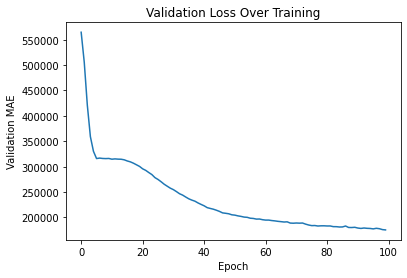

In [ ]:
import matplotlib.pyplot as plt

print(average_mae_history[-1])

plt.plot(average_mae_history)
plt.ylabel('Validation MAE')
plt.xlabel('Epoch')
plt.title('Validation Loss Over Training')
plt.show()